# Data Transformation by Clustering — Concepts & Similarity

> Hands‑on demo to accompany the slide **‘Data Transformation by Clustering — Concepts & Similarity’**.

**What you will learn**
- What clustering is and why similarity/distance matters
- Common distance/similarity measures: **Euclidean**, **Manhattan**, **Cosine**
- The role of **feature scaling** in distance‑based methods
- Mini demos with **k‑means** and **Agglomerative (hierarchical) clustering**
- How to compute and interpret a **silhouette score**
- Practical tips: choosing *k*, detecting outliers, and pitfalls


## 0. Setup (packages)
Run this once in VS Code to install dependencies.

In [1]:
#%pip -q install numpy pandas matplotlib seaborn scikit-learn scipy

## 1. Imports & reproducibility

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

np.random.seed(42)
sns.set_context('notebook')
plt.rcParams['figure.figsize'] = (10,4)

## 2. Concept — Similarity and Dissimilarity
Clustering groups observations so that **within‑cluster** items are similar and **between‑cluster** items are different. We quantify this using a **dissimilarity (distance)** or a **similarity** measure.

- **Euclidean distance** (straight‑line): sensitive to scale.
- **Manhattan distance** (city‑block): robust when axes are not commensurate.
- **Cosine similarity**: compares **direction**, not magnitude; useful for text/TF‑IDF or high‑dimensional features.

> **Key point:** Always check feature **scales**. If one feature has much larger units, it can dominate Euclidean/Manhattan distances. Use `StandardScaler` when appropriate.

## 3. Toy dataset to visualize distances
We’ll build three compact groups in 2‑D, plus a couple of outliers.

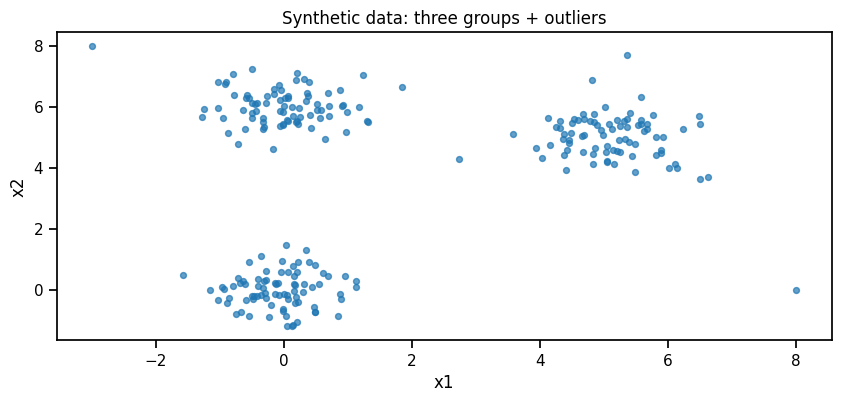

In [3]:
# Three clusters around (0,0), (5,5), (0,6) plus outliers
A = np.random.normal(loc=[0,0], scale=0.6, size=(80,2))
B = np.random.normal(loc=[5,5], scale=0.7, size=(80,2))
C = np.random.normal(loc=[0,6], scale=0.6, size=(80,2))
out = np.array([[8,0], [-3,8]])
X = np.vstack([A,B,C,out])
labels_true = np.array([0]*len(A) + [1]*len(B) + [2]*len(C) + [-1]*len(out))

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], s=18, alpha=0.7)
ax.set_xlabel('x1'); ax.set_ylabel('x2'); ax.set_title('Synthetic data: three groups + outliers')
plt.show()

## 4. Compare distance measures (small subset)
We’ll compute pairwise distances for the first 6 points using Euclidean, Manhattan, and Cosine to see the differences.

In [4]:
subset = X[:6]
D_euc = pairwise_distances(subset, metric='euclidean')
D_man = pairwise_distances(subset, metric='manhattan')
D_cos = pairwise_distances(subset, metric='cosine')  # cosine distance = 1 - cosine similarity
pd.DataFrame(D_euc).round(2).head()

,0,1,2,3,4,5
0,0.00,1.00,0.44,0.85,0.71,0.61
1,1.00,0.00,1.18,0.72,0.89,1.37
2,0.44,1.18,0.00,1.24,0.49,0.20
3,0.85,0.72,1.24,0.00,1.24,1.43
4,0.71,0.89,0.49,1.24,0.00,0.60


**Observation:** The **ordering** of nearest neighbors can change with the metric, especially when vectors differ in magnitude vs direction.

## 5. Feature scaling matters (Euclidean example)
Let’s artificially stretch the first feature 50x and see how it changes Euclidean distances and clustering.

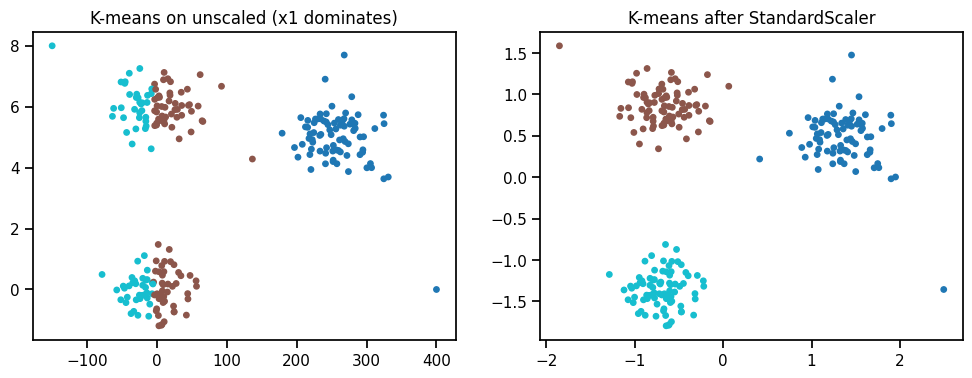

In [5]:
X_skewed = X.copy(); X_skewed[:,0] *= 50  # blow up x1 scale
km_raw = KMeans(n_clusters=3, n_init=10, random_state=42).fit(X_skewed)
sc = StandardScaler().fit(X_skewed)
X_scaled = sc.transform(X_skewed)
km_scaled = KMeans(n_clusters=3, n_init=10, random_state=42).fit(X_scaled)

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].scatter(X_skewed[:,0], X_skewed[:,1], c=km_raw.labels_, s=15, cmap='tab10')
axes[0].set_title('K-means on unscaled (x1 dominates)')
axes[1].scatter(X_scaled[:,0], X_scaled[:,1], c=km_scaled.labels_, s=15, cmap='tab10')
axes[1].set_title('K-means after StandardScaler')
plt.show()

**Takeaway:** Without scaling, the inflated `x1` overwhelms Euclidean distance and distorts clusters. Scaling restores a balanced view of both axes.

## 6. K‑means clustering demo (with silhouette score)
We’ll run K‑means for k=2..6 and plot the **silhouette score** to choose a reasonable k. Higher is better (range −1..+1).

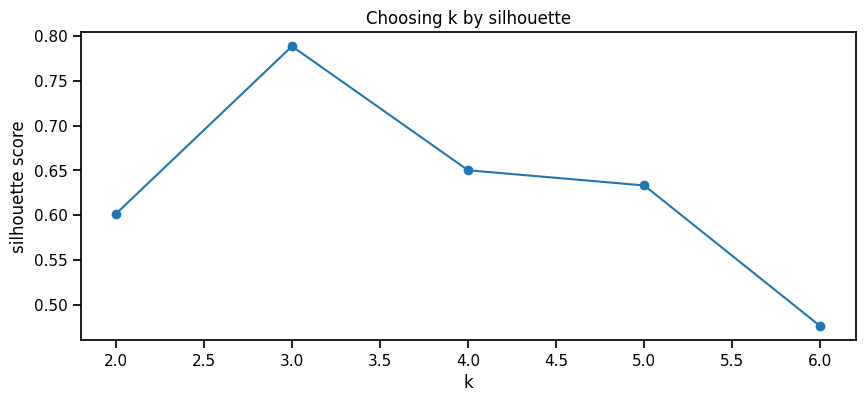

[0.6015859677593521,
 0.7883545264002902,
 0.6501973049909203,
 0.6332897227349819,
 0.47644080359264346]

In [6]:
X_std = StandardScaler().fit_transform(X)
ks = range(2,7)
scores = []
for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_std)
    s = silhouette_score(X_std, labels, metric='euclidean')
    scores.append(s)

fig, ax = plt.subplots()
ax.plot(list(ks), scores, marker='o')
ax.set_xlabel('k'); ax.set_ylabel('silhouette score'); ax.set_title('Choosing k by silhouette')
plt.show()
scores

## 7. Hierarchical clustering + dendrogram (concept)
Hierarchical (agglomerative) clustering starts with points as individual clusters and **merges** the closest pairs. The result can be visualized as a **dendrogram**. Cutting the tree at a chosen height yields a target number of clusters.

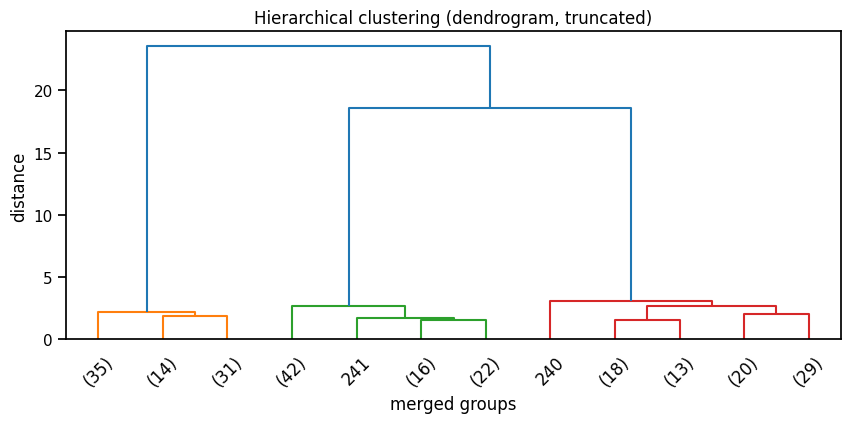

In [7]:
Z = linkage(X_std, method='ward')  # Ward uses Euclidean distances
fig, ax = plt.subplots(figsize=(10,4))
dendrogram(Z, truncate_mode='lastp', p=12, show_leaf_counts=True, leaf_rotation=45, ax=ax)
ax.set_title('Hierarchical clustering (dendrogram, truncated)'); ax.set_xlabel('merged groups'); ax.set_ylabel('distance')
plt.show()

## 8. Agglomerative clustering in scikit‑learn
We’ll take 3 clusters from the hierarchy and visualize the assignments.

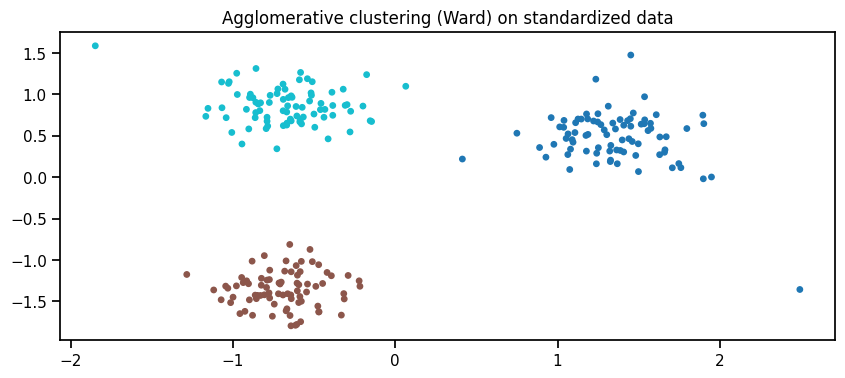

In [8]:
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels_agg = agg.fit_predict(X_std)
fig, ax = plt.subplots()
ax.scatter(X_std[:,0], X_std[:,1], c=labels_agg, cmap='tab10', s=15)
ax.set_title('Agglomerative clustering (Ward) on standardized data')
plt.show()

## 9. Cosine vs Euclidean for high‑dimensional data (mini demo)
We’ll simulate 100 50‑dimensional vectors. K‑means with **cosine distance** is approximated by first **L2‑normalizing** vectors and using Euclidean distance (since for unit vectors, minimizing Euclidean ≈ maximizing cosine similarity).

In [9]:
# 50-D random unit vectors around two centroids
U1 = np.random.normal(size=(50,50)); U1 = U1/np.linalg.norm(U1,axis=1,keepdims=True)
U2 = np.random.normal(size=(50,50)); U2 = U2/np.linalg.norm(U2,axis=1,keepdims=True)
HD = np.vstack([U1,U2])
# L2-normalize rows to approximate cosine-based clustering with Euclidean
HD_norm = HD/np.linalg.norm(HD, axis=1, keepdims=True)
km_hd = KMeans(n_clusters=2, n_init=10, random_state=42).fit(HD_norm)
sil_hd = silhouette_score(HD_norm, km_hd.labels_, metric='euclidean')
sil_hd


0.03038784019446989

## 10. Practical checklist
- **Scale** numeric features before Euclidean/Manhattan‑based clustering.
- Try multiple **metrics** (Euclidean, Cosine) depending on your data type.
- Use **silhouette score** or elbow plots to choose k (heuristics, not guarantees).
- Watch for **outliers**; they can pull centroids or distort dendrogram heights.
- Document your **distance choice** and **preprocessing** so results are reproducible.

---
_Last updated: 2026-02-17 19:16:43 UTC_
